In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten, BatchNormalization,Dropout,GlobalAveragePooling2D
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
import os
import zipfile
import cv2
import requests
from PIL import Image
from io import BytesIO

## Data Collection and Preprocessing

In [ ]:
os.makedirs("dataset",exist_ok=True)
zip_files = ["/content/weapon_images.zip","/content/non_weapon_images.zip"]
extract_dirs = ["/content/dataset/weapon_images", "/content/dataset/non_weapon_images"]

for zip_file, extract_dir in zip(zip_files, extract_dirs):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

In [ ]:
print(f"Number of weapon images: {len(os.listdir('/content/dataset/weapon_images'))}")
print(f"Number of non-weapon images: {len(os.listdir('/content/dataset/non_weapon_images'))}")

Number of weapon images: 391
Number of non-weapon images: 391


In [ ]:
data_dir = ["/content/dataset/weapon_images", "/content/dataset/non_weapon_images"]
image_exts = ["jpeg", "png", "gif", "bmp"]

for image_class in data_dir:
  for image in os.listdir(image_class):
    image_path = os.path.join(image_class, image)
    extension = image.split('.')[-1].lower()

    if extension == "jpg":
      img = Image.open(image_path)
      new_path = os.path.join(image_class, image.replace(".jpg", ".jpeg"))
      img.convert("RGB").save(new_path, "JPEG")
      os.remove(image_path)

      image_path = new_path
      extension = "jpeg"

    if extension not in image_exts:
      os.remove(image_path)
      print(f"Removed: {image} with extension: {extension}")

Removed: vector4.svg with extension: svg
Removed: vector11.svg with extension: svg
Removed: vector13.svg with extension: svg
Removed: What-are-Chemical-weapons.webp with extension: webp
Removed: vector5.svg with extension: svg
Removed: vector.svg with extension: svg
Removed: vector6.svg with extension: svg
Removed: vector8.svg with extension: svg
Removed: which-weapons-are-most-commonly-used-for-homicides.webp with extension: webp
Removed: vector10.svg with extension: svg
Removed: vector14.svg with extension: svg
Removed: vector2.svg with extension: svg
Removed: vector9.svg with extension: svg
Removed: vector3.svg with extension: svg
Removed: vector7.svg with extension: svg
Removed: vector12.svg with extension: svg
Removed: vector4.svg with extension: svg
Removed: list20of20co20curricular20activities20in20school.webp with extension: webp
Removed: vector11.svg with extension: svg
Removed: vector13.svg with extension: svg
Removed: 40-Fun-Classroom-Games-And-Activities-For-Kids.jpg.webp w

In [ ]:
non_weapon_path = "/content/dataset/non_weapon_images"

# Count images in both folders
start = len(os.listdir(non_weapon_path))
endLimit = len(os.listdir('/content/dataset/weapon_images'))

# List files in the non-weapons folder
files = sorted(os.listdir(non_weapon_path))  # Sorting ensures consistency

# Calculate how many images to delete
num_to_delete = max(0, start - endLimit)

# Delete the last few images
for i in range(num_to_delete):
    file_to_delete = os.path.join(non_weapon_path, files[-1])  # Get the last file
    os.remove(file_to_delete)  # Delete the file
    files.pop()  # Remove from array

print(f"Deleted {num_to_delete} images from 'non_weapon_images' to balance the dataset.")


Deleted 401 images from 'non_weapon_images' to balance the dataset.


In [ ]:
data = tf.keras.utils.image_dataset_from_directory('dataset',image_size=(256,256))

Found 782 files belonging to 2 classes.


In [ ]:
batch = data.as_numpy_iterator().next()

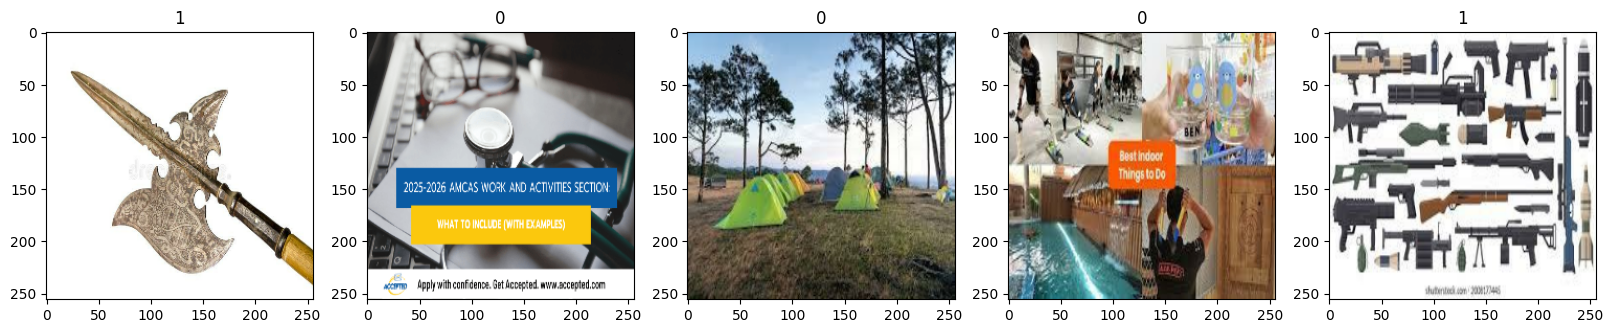

In [ ]:
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
# normalizing images
'''
def scale(x, y):
    return (x / 255, y)

data = data.map(scale)
'''

data = data.map(lambda x,y:(x/255,y))

In [ ]:
# splitting data into train, validation and testing
train_size = int(len(data)*.7)
val_size = int(len(data)*.2) + 1
test_size = int(len(data)*.1) + 1

train_data = data.take(train_size)
val_data = data.skip(train_size).take(val_size)
test_data = data.skip(train_size+val_size).take(test_size)

# Model Building and Training

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # output (1/0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      14,745,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,769,697 (56.34 MB)

 Trainable params: 14,769,697 (56.34 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
history = model.fit(train_data, epochs=10, validation_data=val_data)

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.5422 - loss: 1.0779 - val_accuracy: 0.6042 - val_loss: 0.6620
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.7098 - loss: 0.5824 - val_accuracy: 0.8021 - val_loss: 0.4737
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.8187 - loss: 0.4024 - val_accuracy: 0.8490 - val_loss: 0.3639
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.8688 - loss: 0.3044 - val_accuracy: 0.9115 - val_loss: 0.2631
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.8861 - loss: 0.3137 - val_accuracy: 0.9167 - val_loss: 0.2044
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.9414 - loss: 0.1956 - val_accuracy: 0.9271 - val_loss: 0.2383
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.9717 - loss: 0.1141 - val_accuracy: 0.9531 - val_loss: 0.1692
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.9709 - loss: 0.0910 - val_accuracy: 0.9688 - val_loss:

# Model Evaluation

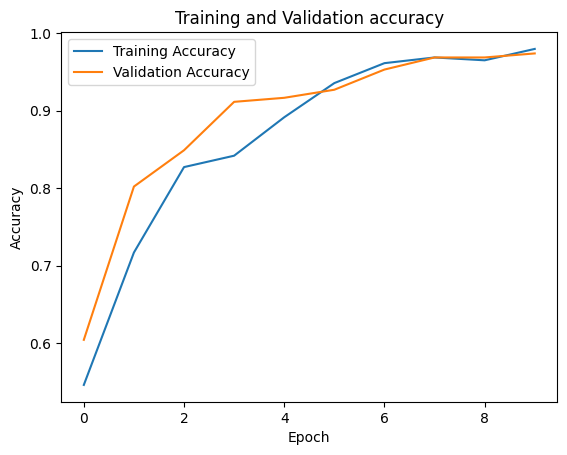

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

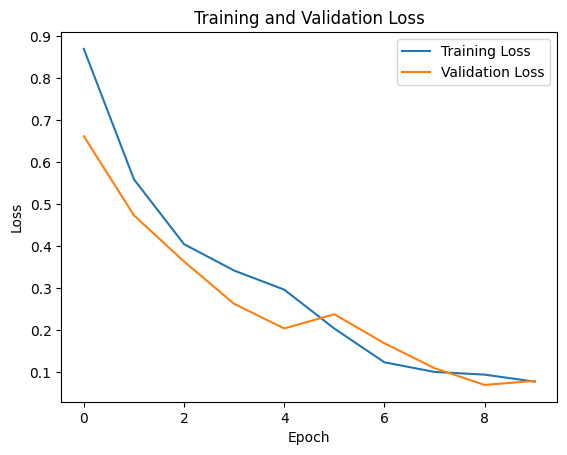

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


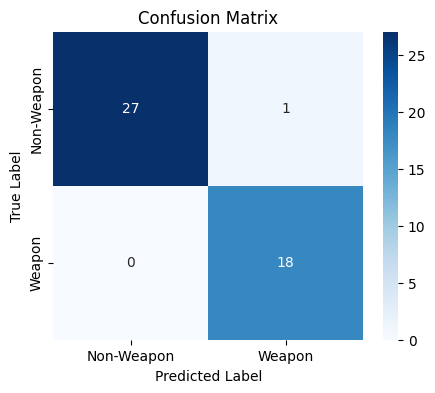

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        28
           1       0.95      1.00      0.97        18

    accuracy                           0.98        46
   macro avg       0.97      0.98      0.98        46
weighted avg       0.98      0.98      0.98        46

Precision: 0.9474
Recall: 1.0000
Accuracy: 0.9783


In [ ]:
# Define evaluation metrics
pre = tf.keras.metrics.Precision()
re = tf.keras.metrics.Recall()
acc = tf.keras.metrics.BinaryAccuracy()

# Store actual labels and predictions
y_true_all = []
y_pred_all = []

# Iterate over test dataset
for batch in test_data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    yhat_binary = (yhat > 0.5).astype(int)  # Convert probabilities to binary (0 or 1)

    # Update metrics
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

    # Collect true and predicted values for confusion matrix
    y_true_all.extend(y)
    y_pred_all.extend(yhat_binary)

# Convert lists to numpy arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# Compute confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Weapon", "Weapon"], yticklabels=["Non-Weapon", "Weapon"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(y_true_all, y_pred_all))

# Print overall metrics
print(f"Precision: {pre.result().numpy():.4f}")
print(f"Recall: {re.result().numpy():.4f}")
print(f"Accuracy: {acc.result().numpy():.4f}")


# Model Testing

In [ ]:
# URL of the image
url = "https://imgs.search.brave.com/WWhb85iAkc1hF1xQZ4C5b2tzil2iy1kTbLH8ef5AX4I/rs:fit:860:0:0:0/g:ce/aHR0cHM6Ly9tZWRp/YS5oc3dzdGF0aWMu/Y29tL2V5SmlkV05y/WlhRaU9pSmpiMjUw/Wlc1MExtaHpkM04w/WVhScFl5NWpiMjBp/TENKclpYa2lPaUpu/YVdaY0wyZDFiakV1/YW5Cbklpd2laV1Jw/ZEhNaU9uc2ljbVZ6/YVhwbElqcDdJbmRw/WkhSb0lqbzBNREI5/ZlgwPQ"

# Fetch the image from the URL through by placing GET request
response = requests.get(url)
img = tf.keras.preprocessing.image.load_img(BytesIO(response.content), target_size=(256, 256))

# Convert to NumPy array
img_array = tf.keras.preprocessing.image.img_to_array(img)

# Reshaping image dimensions
img_array = img_array.reshape(1, 256, 256, 3)

# image predictino
yhat = model.predict(img_array / 255)

In [ ]:
"{:.4f}".format(yhat[0][0])

'0.9882'